In [1]:
import os
import numpy as np
from HSI_class import HSI
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go

In [2]:
dataset_path = r"C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets"

datasets = []
dataset_used = 1

max = 9
i = 0
for filename in os.listdir(dataset_path):
    if i > 5:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1


Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM03.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM04.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM05.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM06.mat


In [3]:

hsi = datasets[3]
hsi_image = hsi.img
hsi_gt = hsi.gt

In [4]:
def normalize_channel(channel):
    channel = channel - channel.min()
    channel = channel / (channel.max() + 1e-8)  # avoid divide by zero
    return (channel * 255).astype(np.uint8)

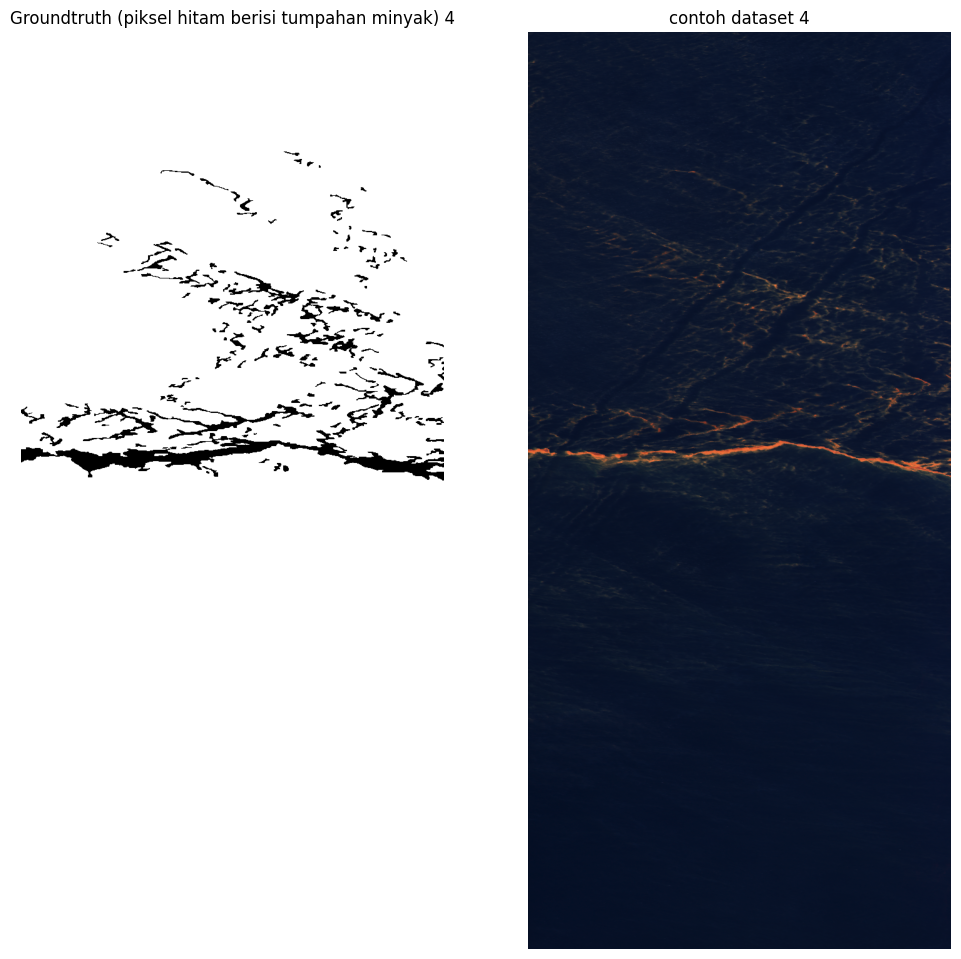

In [5]:
# Extract RGB bands
data = hsi_image

rgb = np.dstack([
    data[:, :, 50],  # R
    data[:, :, 30],  # G
    data[:, :, 17],  # B
]).astype(np.float32)  # ensure float for safe division
rgb_normalized = np.dstack([
    normalize_channel(rgb[:, :, 0]),
    normalize_channel(rgb[:, :, 1]),
    normalize_channel(rgb[:, :, 2])
])

# Normalize for display
rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))
fig, axs = plt.subplots(1, 2, figsize=(12, 64))

im1 = axs[0].imshow(1 - hsi_gt, cmap='gray')
axs[0].set_title(f'Groundtruth (piksel hitam berisi tumpahan minyak) 4')
axs[0].axis('off')


axs[1].imshow(rgb)
axs[1].set_title(f'contoh dataset 4')
axs[1].axis('off')
# fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)


plt.axis('off')
plt.show()


In [8]:
data_small = data[::10, ::10, :]  # smaller version
rgb = np.dstack([
    normalize_channel(data_small[:, :, 50]),  # R
    normalize_channel(data_small[:, :, 30]),  # G
    normalize_channel(data_small[:, :, 17])   # B
])

# Select 4 other bands to show below (besides RGB)
# Select 4 bands for grayscale layers (e.g., before RGB)
selected_bands = [10, 40, 100, 150]

# Create grayscale layers first
grayscale_layers = [(data_small[:, :, b] - data_small[:, :, b].min()) /
                    (data_small[:, :, b].max() - data_small[:, :, b].min() + 1e-8)
                    for b in selected_bands]

# Final layer stack: grayscale first, RGB last
layer_images = grayscale_layers + [rgb]





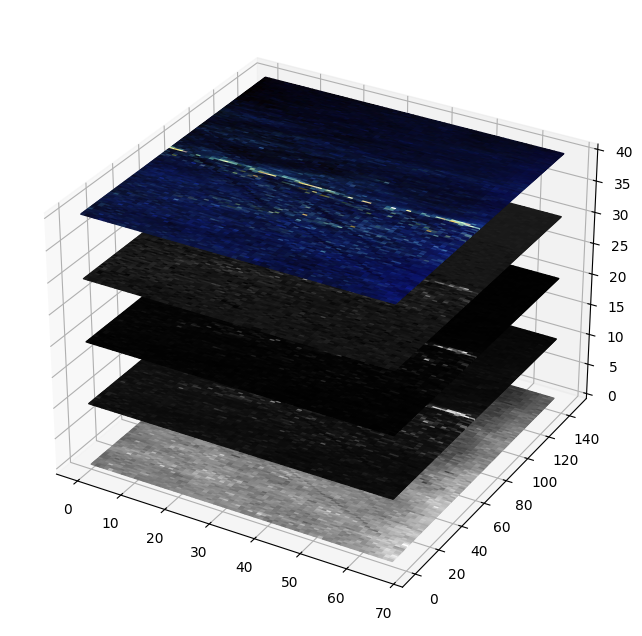

In [9]:
# Plot each layer in 3D stack
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

offset = 10
for i, layer in enumerate(layer_images):
    z = i * offset
    x = np.arange(layer.shape[1])
    y = np.arange(layer.shape[0])
    X, Y = np.meshgrid(x, y)
    Z = np.full_like(X, z)

    if i == len(layer_images) - 1:
        # RGB layer on top
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb / 255.0, shade=False)
    else:
        # Grayscale layers
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                        facecolors=plt.cm.gray(layer), shade=False)


In [ ]:
# Plot as a stack of layers
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

offset = 10  # vertical gap between layers
for i, layer in enumerate(layer_images):
    z = i * offset
    x = np.arange(layer.shape[1])
    y = np.arange(layer.shape[0])
    X, Y = np.meshgrid(x, y)
    Z = np.full_like(X, z)  # FIXED: make Z same shape as X, Y
    
    if i == 0:
        x=1
        # RGB layer
        # ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb / 255.0, shade=False)
    else:
        # Grayscale layers
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                        facecolors=plt.cm.gray(layer),
                        shade=False)


In [ ]:
# Downsample spatial and spectral dimensions for visualization
data_small = data[::20, ::20, ::10]  # (H, W, B)

# Get coordinates
x, y, z = data_small.shape
xx, yy, zz = np.meshgrid(np.arange(y), np.arange(x), np.arange(z), indexing='ij')

# Flatten the coordinate arrays
xx = xx.flatten()
yy = yy.flatten()
zz = zz.flatten()

# Flatten hyperspectral data
intensities = data_small.flatten()

# Create a color map based on reflectance value (mean or intensity)
# Optional: normalize
intensities = (intensities - intensities.min()) / (intensities.max() - intensities.min())

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xx, yy, zz, c=intensities, cmap='inferno', alpha=0.6, s=5)

ax.set_xlabel("Width")
ax.set_ylabel("Height")
ax.set_zlabel("Band Index")
ax.set_title("Hyperspectral Image Cube (Downsampled)")
plt.colorbar(scatter, label="Normalized Reflectance")
plt.show()

In [ ]:
row, col = 100, 100  # example pixel
spectrum = data[row, col, :]

plt.figure(figsize=(10, 4))
plt.plot(np.arange(224), spectrum)
plt.title(f"Spectral Signature at Pixel ({row},{col})")
plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.grid(True)
plt.show()
